### 1. IMPORT LIBRARIES AND CIFAR 10, PREPARE DATA

In [34]:
# general
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import time
import matplotlib.pyplot as plt
% matplotlib inline

# dataset
from keras.datasets import cifar10

# modeling tools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


Check and Prepare Data:

In [35]:
# split data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# check data dimension
print('training data shape: {}'.format(x_train.shape))
print('test data shape: {}'.format(x_test.shape))

170500096/170498071 [==============================] - 29s 0us/step
training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [36]:
# check labels
labels = []
for y in y_train.flatten():
    if y not in labels:
        labels.append(y)
print('training labels are: {}'.format(labels))
print('# labels: {}'.format(len(labels)))

training labels are: [6, 9, 4, 1, 2, 7, 8, 3, 5, 0]
# labels: 10


In [0]:
# Convert class vectors to one-hot encoded vectors.
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [0]:
# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

x_train = np.reshape(x_train,(50000,3072))
x_test = np.reshape(x_test,(10000,3072))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalization of pixel values (to [0-1] range)

x_train /= 255
x_test /= 255

### 2. HELP FUNCTION

In [0]:
# plot the accuracy and loss of training process

def plotAcc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'lower right')
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper right')

In [0]:
# get the best accuracy result

def getBest(record):
    max_acc = 0
    experiment = None
    for value in record.values():
        max_acc = max(max_acc, value[1])

    for key in record.keys():
        if record[key][1] == max_acc:
            experiment = key
      
    return max_acc, experiment, record[experiment][3]

In [0]:
# get the summary of all experiments

import pandas as pd

def get_allResult(record):
    df_result = pd.DataFrame()
    length = len(list(record.keys()))
    df_result['Experiment'] = list(record.keys())
    df_result['Loss'] = [list(record.values())[i][0] for i in range(length)]
    df_result['Accuracy'] = [list(record.values())[i][1] for i in range(length)]
    return df_result

### 3. EXPERIMENTS - TEST WITH OPTIMIZER & LR

#### 1. Set up hyperparameters for optimizer & learnig rate

In [41]:
# record optimizer information in string list
list_lr = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
list_opt_name = ['SGD', 'Momentum', 'RMSprop', 'Adam', 'Adagrad', 'Adadelta']

list_test = []
for i in list_lr:
    for j in list_opt_name:
        list_test += [str(j) + ' with learning rate @ ' + str(i)]
        
print(list_test[:6])

['SGD with learning rate @ 1e-05', 'Momentum with learning rate @ 1e-05', 'RMSprop with learning rate @ 1e-05', 'Adam with learning rate @ 1e-05', 'Adagrad with learning rate @ 1e-05', 'Adadelta with learning rate @ 1e-05']


In [42]:
# build list of optimizers
list_optimizer = []
for i in list_lr:
    list_optimizer += \
    [keras.optimizers.SGD(lr = i)] +  \
    [keras.optimizers.SGD(lr = i, momentum = 0.9)] + \
    [keras.optimizers.RMSprop(lr = i)] + \
    [keras.optimizers.Adam(lr = i)] + \
    [keras.optimizers.Adagrad(lr = i)] + \
    [keras.optimizers.Adadelta(lr = i)]
    
print(list_optimizer[:6])

[<keras.optimizers.SGD object at 0x7fb5987d66d8>, <keras.optimizers.SGD object at 0x7fb5d67c5c88>, <keras.optimizers.RMSprop object at 0x7fb5d67c5828>, <keras.optimizers.Adam object at 0x7fb5d67c5a20>, <keras.optimizers.Adagrad object at 0x7fb5d67c5dd8>, <keras.optimizers.Adadelta object at 0x7fb59879beb8>]


#### 2. Control other conditions and hyperparameters

In [0]:
# set conditions
n_class = 10
input_dimension = 32*32*3

# hyper parameters
n_neuron = 256
batch_size = 128
dropout_rate = 0.2
epochs = 20
activation = 'relu'

# record hyper parameter information in dictionary                 
param_dict = {
        'num_neurons': 256,
        'num_layers ': 2,
        'batch_size': 128,
        'dropout_rate': 0.2,
        'epochs': 20,
        'activation function': 'relu'
    }

#### 3. Set up experiment function

In [0]:
def experiment_optimizer(list_optimizer):
    
    record = {}    
    for i, _ in enumerate(list_optimizer):
        
        model = Sequential()
        model.add(Dense(n_neuron, activation = activation, input_dim = input_dimension))
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_neuron, activation = activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_class, activation = 'softmax'))

        model.compile(optimizer = _,
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])

        start = time.clock()
        exp_optimizer = model.fit(x_train, 
                                  y_train, 
                                  epochs = epochs, 
                                  batch_size = batch_size,
                                  verbose = 2,
                                  validation_data = (x_test, y_test))
        elapsed = (time.clock() - start)
        scores = model.evaluate(x_test, y_test, verbose=1)
        
        # record experiment information:
        record[str(list_test[i])] = [scores[0], scores[1], elapsed, exp_optimizer]
        
        # print experiment name:
        print('*******************************************************')
        print('=======================================================')
        print('Experiment' + str(i) + ':'  + '\t' + str(list_test[i]))
        print('=======================================================')
        # print all used parameters for this model
#         for i,j in param_dict.items():
#             print(str(i) + '\t' + str(j)) 
#             print('-------------------------------------------------------')
            
        # print running time used
        print('Time Used: {}'.format(elapsed))
        print('-------------------------------------------------------')
        
        # print best loss and accuracy result
        print('Test loss:', scores[0])
        print('-------------------------------------------------------')
        print('Test accuracy:', scores[1])
        
        print('*******************************************************')

        
    return record

#### 4. Experiment

In [45]:
record = experiment_optimizer(list_optimizer)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
 - 5s - loss: 2.4596 - acc: 0.0998 - val_loss: 2.3952 - val_acc: 0.0985
Epoch 2/20
 - 2s - loss: 2.4374 - acc: 0.1000 - val_loss: 2.3765 - val_acc: 0.0980
Epoch 3/20
 - 2s - loss: 2.4194 - acc: 0.0984 - val_loss: 2.3624 - val_acc: 0.0966
Epoch 4/20
 - 2s - loss: 2.4072 - acc: 0.1015 - val_loss: 2.3511 - val_acc: 0.0957
Epoch 5/20
 - 2s - loss: 2.3933 - acc: 0.0999 - val_loss: 2.3419 - val_acc: 0.0968
Epoch 6/20
 - 2s - loss: 2.3821 - acc: 0.1018 - val_loss: 2.3343 - val_acc: 0.0981
Epoch 7/20
 - 2s - loss: 2.3770 - acc: 0.0987 - val_loss: 2.3278 - val_acc: 0.1033
Epoch 8/20
 - 2s - loss: 2.3690 - acc: 0.1033 - val_loss: 2.3221 - val_acc: 0.1094
Epoch 9/20
 - 2s - loss: 2.3634 - acc: 0.1029 - val_loss: 2.3172 - val_acc: 0.1138
Epoch 10/20
 - 2s - loss: 2.3584 - acc: 0.1046 - val_loss: 2.3128 - val_acc: 0.1186
Epoch 11/20
 - 2s - loss: 2.3531 - acc: 0.1063 - val_loss: 2.3088 - val_acc: 0.1205
Epoch 12/20
 - 2s - loss: 2.3506 - 

### 4. SUMMRIZE EXPERIMENTS RESULTS

#### 1. Best result

In [109]:
max_acc, experiment, history = getBest(record)
print('The Best Result is:')
max_acc, experiment

The Best Result is:


(0.5105, 'Adam with learning rate @ 0.0003')

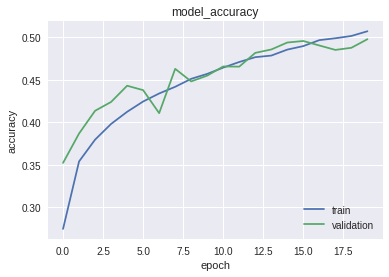

In [51]:
plotAcc(history)

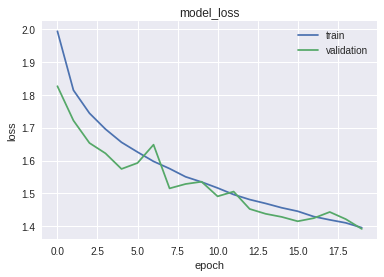

In [52]:
plotLoss(history)

#### 2. Result summary

In [0]:
df_result = get_allResult(record)

# add control parameters

df_result['activation'] = 'relu'
df_result['num_layers'] = 3
df_result['num_neurons'] = 256
df_result['batch_size'] = 128
df_result['dropout_rate'] = 0.2
df_result['epochs'] = 20

In [151]:
df_result.rename(columns = {"Experiment": "optimizer"}, inplace = True)
df_result.sort_values(by = 'Accuracy', axis = 0, ascending = False)

,optimizer,Loss,Accuracy,activation,num_layers,num_neurons,batch_size,dropout_rate,epochs
21,Adam with learning rate @ 0.0003,1.389348,0.5105,relu,3,256,128,0.2,20
48,SGD with learning rate @ 0.1,1.380092,0.5086,relu,3,256,128,0.2,20
42,SGD with learning rate @ 0.03,1.393608,0.5078,relu,3,256,128,0.2,20
31,Momentum with learning rate @ 0.003,1.389523,0.5067,relu,3,256,128,0.2,20
20,RMSprop with learning rate @ 0.0003,1.400199,0.5050,relu,3,256,128,0.2,20
15,Adam with learning rate @ 0.0001,1.388294,0.5040,relu,3,256,128,0.2,20
37,Momentum with learning rate @ 0.01,1.392945,0.5011,relu,3,256,128,0.2,20
53,Adadelta with learning rate @ 0.1,1.392093,0.4979,relu,3,256,128,0.2,20
14,RMSprop with learning rate @ 0.0001,1.426306,0.4947,relu,3,256,128,0.2,20
25,Momentum with learning rate @ 0.001,1.465026,0.4876,relu,3,256,128,0.2,20
